In [45]:
import pandas as pd
df= pd.read_excel('data/insurance_data.xlsx')


In [49]:
import os

# Assuming 'sampled_data' is your DataFrame after sampling
# Sampled Data (replace with your actual sampled data)
sampled_data = df.iloc[::5, :]  # This samples every 5th row

# Define the exact directory path where you want to save the data
data_dir = r'H:\fsds\insurance\notebook\data'

# Check if the directory exists, and if not, create it
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Define the file path where the sampled data will be saved
file_path = os.path.join(data_dir, 'sampled_data.csv')

# Save the sampled data to a CSV file
sampled_data.to_csv(file_path, index=False)

print(f"Sampled data saved to {file_path}")


Sampled data saved to H:\fsds\insurance\notebook\data\sampled_data.csv


In [64]:
df = sampled_data.copy()
df.shape

(200000, 12)

In [65]:
(df.replace('', pd.NA).isna().sum()/ len(df) * 100).round(2).apply(lambda x: f"{x}%")

age                        4.05%
gender                      2.4%
bmi                         0.0%
children                   3.21%
smoker                      0.0%
region                      0.0%
medical_history           25.17%
family_medical_history    25.06%
exercise_frequency          0.0%
occupation                 3.21%
coverage_level              0.0%
charges                     0.0%
dtype: object

In [66]:
import numpy as np
df.replace('', np.nan, inplace=True)

In [67]:
# Convert numerical columns to float
numerical_columns = ['age', 'bmi', 'children', 'charges']
df[numerical_columns] = df[numerical_columns].astype(float)

# Convert categorical columns to category type
categorical_columns = ['gender', 'smoker', 'region', 'medical_history', 'family_medical_history', 'exercise_frequency', 'occupation', 'coverage_level']
df[categorical_columns] = df[categorical_columns].astype('category')

# Display the DataFrame with updated dtypes
print(df.dtypes)

age                        float64
gender                    category
bmi                        float64
children                   float64
smoker                    category
region                    category
medical_history           category
family_medical_history    category
exercise_frequency        category
occupation                category
coverage_level            category
charges                    float64
dtype: object


In [68]:
df['age'] = df['age'].fillna(df['age'].median())
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

In [69]:
median_children = df['children'].median()
rounded_median_children = round(median_children)
df['children'] = df['children'].fillna(rounded_median_children)

In [70]:
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])

In [71]:
for col in ['medical_history', 'family_medical_history']:
    if 'No history' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('No history')

# Replace NaN values with 'No history'
df['medical_history'] = df['medical_history'].fillna('No history')
df['family_medical_history'] = df['family_medical_history'].fillna('No history')

In [72]:
(df.isna().sum()/ len(df) * 100).round(2).apply(lambda x: f"{x}%")

age                       0.0%
gender                    0.0%
bmi                       0.0%
children                  0.0%
smoker                    0.0%
region                    0.0%
medical_history           0.0%
family_medical_history    0.0%
exercise_frequency        0.0%
occupation                0.0%
coverage_level            0.0%
charges                   0.0%
dtype: object

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

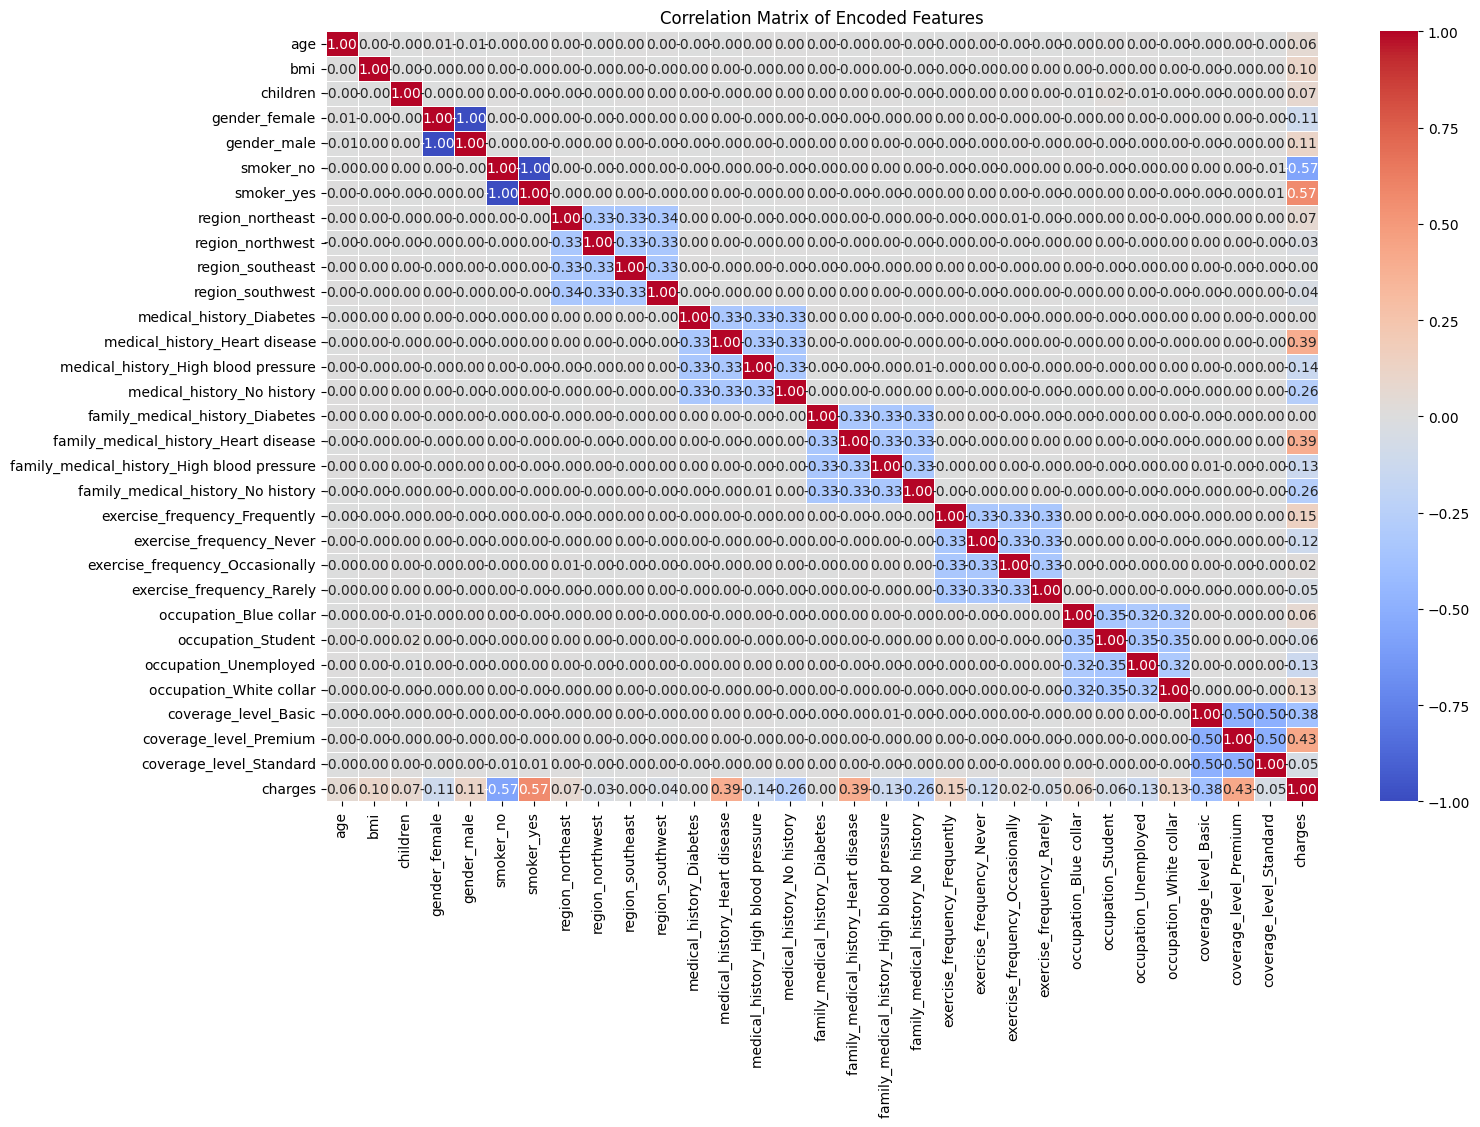

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Define categorical and numerical features
categorical_features = ['gender', 'smoker', 'region', 'medical_history', 'family_medical_history', 'exercise_frequency', 'occupation', 'coverage_level']
numerical_features = ['age', 'bmi', 'children']


# Create preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # No transformation for numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-Hot Encoding for categorical features
    ]
)

# Apply the preprocessor to transform the features
X_encoded = preprocessor.fit_transform(X)

# Create a DataFrame from the encoded data
encoded_feature_names = (numerical_features +
                         list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Add the target variable to the DataFrame
encoded_df['charges'] = y.values

# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

# Display the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Features')
plt.show()

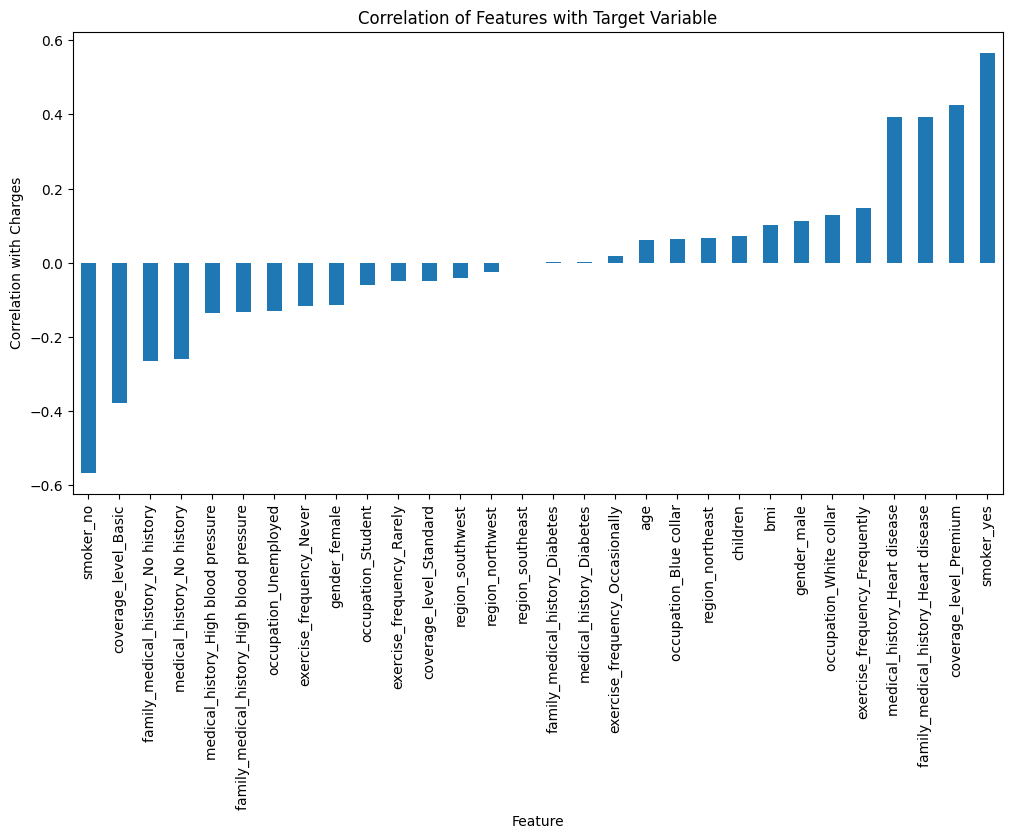

In [75]:
# Compute correlation of each feature with the target variable
target_correlation = encoded_df.corr()['charges'].drop('charges')

# Plot bar chart for correlations with target
plt.figure(figsize=(12, 6))
target_correlation.sort_values().plot(kind='bar')
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Feature')
plt.ylabel('Correlation with Charges')
plt.show()


In [76]:

# One-Hot Encoding of categorical columns
categorical_cols = ['gender', 'smoker', 'region', 'medical_history', 'family_medical_history','exercise_frequency', 'coverage_level', 'occupation']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Calculate correlation matrix
correlation_matrix = df_encoded.corr()

# Target variable
target_variable = 'charges'

# Define the correlation threshold
threshold = 0.05  # Adjust this threshold as needed

# Filter features based on correlation with the target variable
relevant_features = correlation_matrix[target_variable][(correlation_matrix[target_variable] > threshold) | (correlation_matrix[target_variable] < -threshold)].index

# Retain only relevant features
df_relevant = df_encoded[relevant_features]

# Ensure the target variable is included
if target_variable not in df_relevant.columns:
    df_relevant[target_variable] = df_encoded[target_variable]

# Display the retained features
print(f"Features retained: {df_relevant.columns.tolist()}")

Features retained: ['age', 'bmi', 'children', 'charges', 'gender_male', 'smoker_yes', 'medical_history_Heart disease', 'medical_history_High blood pressure', 'medical_history_No history', 'family_medical_history_Heart disease', 'family_medical_history_High blood pressure', 'family_medical_history_No history', 'exercise_frequency_Never', 'exercise_frequency_Rarely', 'coverage_level_Premium', 'occupation_Student', 'occupation_Unemployed', 'occupation_White collar']


In [77]:
df_no_outliers = df_relevant.copy()

In [78]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the target variable
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the thresholds
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")


Lower bound for outliers: 4321.9464027141385
Upper bound for outliers: 29058.059904848575


In [79]:
# Filter the DataFrame to remove outliers in the target variable
df_no_outliers = df_no_outliers[(df_no_outliers['charges'] >= lower_bound) & (df_no_outliers['charges'] <= upper_bound)]

# Verify the number of rows after removing outliers
print(f"Number of rows after removing outliers: {df_no_outliers.shape[0]}")


Number of rows after removing outliers: 199576


In [80]:
df_no_outliers.corr()

,age,bmi,children,charges,gender_male,smoker_yes,medical_history_Heart disease,medical_history_High blood pressure,medical_history_No history,family_medical_history_Heart disease,family_medical_history_High blood pressure,family_medical_history_No history,exercise_frequency_Never,exercise_frequency_Rarely,coverage_level_Premium,occupation_Student,occupation_Unemployed,occupation_White collar
age,1.000000,0.001631,-0.003521,0.059382,-0.005512,0.000504,-0.001930,0.002627,0.000730,-0.001555,0.000497,0.000086,0.003382,-0.001861,0.000483,0.001801,0.001447,-0.001178
bmi,0.001631,1.000000,-0.002081,0.101315,-0.000191,-0.003326,-0.001176,-0.001635,0.001518,-0.003504,0.001486,-0.001161,-0.002818,0.001857,-0.001896,-0.002477,0.001109,0.000503
children,-0.003521,-0.002081,1.000000,0.071178,0.002243,-0.002743,-0.005738,0.002571,0.002581,-0.000733,0.001547,-0.001756,0.000511,0.000253,-0.001311,0.017704,-0.007122,-0.005008
charges,0.059382,0.101315,0.071178,1.000000,0.111839,0.565551,0.386810,-0.132790,-0.258846,0.387585,-0.130369,-0.262380,-0.113575,-0.048516,0.421586,-0.058875,-0.127258,0.127604
gender_male,-0.005512,-0.000191,0.002243,0.111839,1.000000,0.002957,-0.003741,0.004934,-0.001264,0.000119,0.000678,-0.001873,-0.000977,-0.001296,-0.002810,-0.000576,-0.002343,0.000448
smoker_yes,0.000504,-0.003326,-0.002743,0.565551,0.002957,1.000000,-0.001305,-0.003544,0.002333,-0.004355,0.000122,0.001223,0.003512,-0.004086,-0.006204,0.003009,0.001197,-0.001910
medical_history_Heart disease,-0.001930,-0.001176,-0.005738,0.386810,-0.003741,-0.001305,1.000000,-0.331046,-0.332708,-0.006718,0.002201,-0.001596,-0.000817,0.003056,-0.005116,0.002524,0.002659,-0.003757
medical_history_High blood pressure,0.002627,-0.001635,0.002571,-0.132790,0.004934,-0.003544,-0.331046,1.000000,-0.335553,0.001573,-0.003012,0.006426,0.002539,-0.001376,-0.000799,-0.003630,0.000557,0.000729
medical_history_No history,0.000730,0.001518,0.002581,-0.258846,-0.001264,0.002333,-0.332708,-0.335553,1.000000,0.002407,-0.001220,0.000253,-0.002289,-0.000484,0.002804,0.003888,0.000272,-0.001870
family_medical_history_Heart disease,-0.001555,-0.003504,-0.000733,0.387585,0.000119,-0.004355,-0.006718,0.001573,0.002407,1.000000,-0.332505,-0.333451,-0.002177,0.005869,-0.004061,0.002600,-0.000144,-0.003099


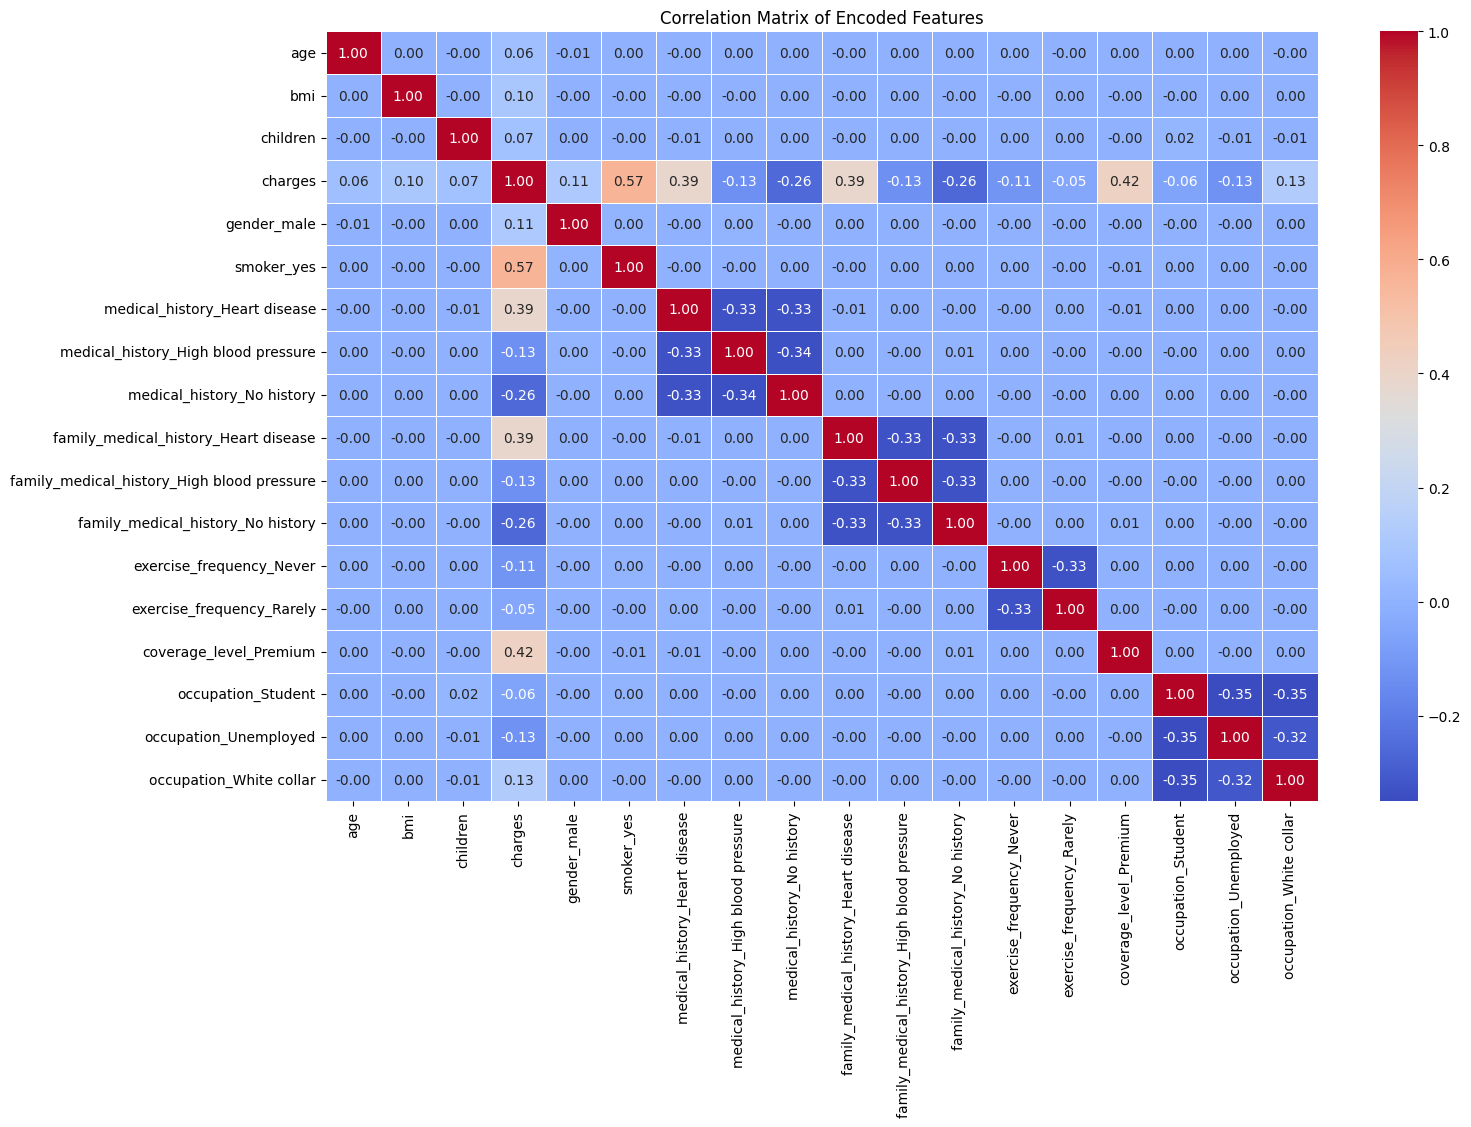

In [81]:
# Display the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(df_no_outliers.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Features')
plt.show()

In [82]:
df_no_outliers.head(10)

,age,bmi,children,charges,gender_male,smoker_yes,medical_history_Heart disease,medical_history_High blood pressure,medical_history_No history,family_medical_history_Heart disease,family_medical_history_High blood pressure,family_medical_history_No history,exercise_frequency_Never,exercise_frequency_Rarely,coverage_level_Premium,occupation_Student,occupation_Unemployed,occupation_White collar
0,46.0,21.45,5.0,20460.307669,True,True,False,False,False,False,False,True,True,False,True,False,False,False
5,55.0,36.41,0.0,11896.836613,False,True,False,False,True,False,False,True,True,False,False,True,False,False
10,21.0,42.08,1.0,18996.131561,True,True,False,False,True,False,False,False,False,True,True,True,False,False
15,36.0,39.17,2.0,13683.049130,True,True,False,True,False,False,False,True,False,False,False,True,False,False
20,25.0,39.82,3.0,11014.284341,True,False,False,False,False,False,False,True,False,False,False,False,False,True
25,60.0,23.83,2.0,16140.478462,False,False,True,False,False,False,False,True,False,True,True,True,False,False
30,44.0,41.15,4.0,16161.137819,True,False,True,False,False,False,True,False,False,False,False,False,False,True
35,38.0,25.90,4.0,17034.559108,False,True,False,False,True,False,False,False,False,False,False,True,False,False
40,44.0,24.01,1.0,8713.333376,False,False,False,False,False,False,False,False,True,False,False,True,False,False
45,35.0,49.01,4.0,14612.231337,True,False,True,False,False,False,False,True,True,False,False,False,True,False


In [83]:
df_no_outliers.shape

(199576, 18)

In [50]:
!nvidia-smi

Fri Sep  6 16:57:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              1W /   50W |     116MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming df_no_outliers is your DataFrame with no outliers
X = df_no_outliers.drop('charges', axis=1)
y = df_no_outliers['charges']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', device = 'cuda', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
}

# Grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

# Residuals
residuals = y_test - y_pred

# Q-Q plot of residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()


h:\fsds\insurance\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


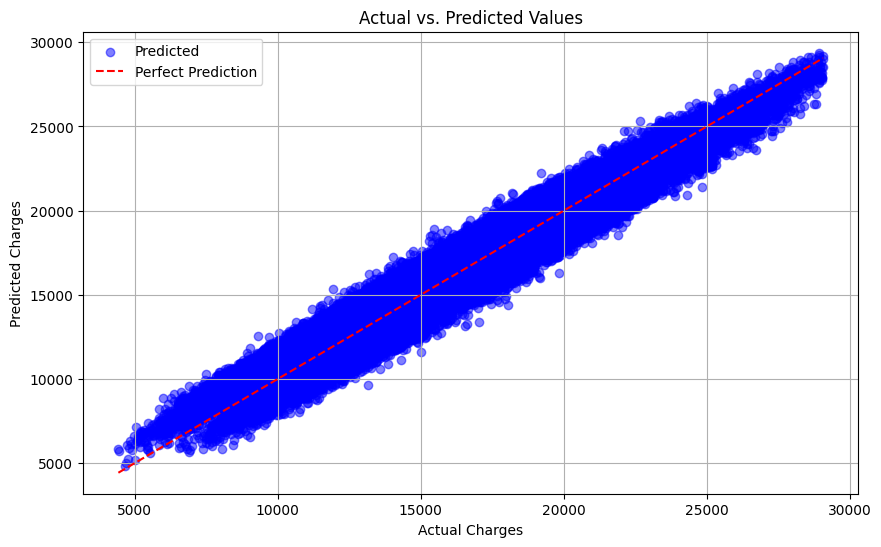

In [25]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted', color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
df_no_outliers.shape

(199576, 18)

In [27]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


# Scale the data
scaler = StandardScaler()
X_train_no_outliers_scaled = scaler.fit_transform(X_train)
X_test_no_outliers_scaled = scaler.transform(X_test)

# Train a Huber model with increased iterations
huber_model = HuberRegressor(max_iter=1000)
huber_model.fit(X_train_no_outliers_scaled, y_train)

# Make predictions
y_pred = huber_model.predict(X_test_no_outliers_scaled)

# Calculate evaluation metrics
rmse_no_outliers = root_mean_squared_error(y_test, y_pred)
mae_no_outliers = mean_absolute_error(y_test, y_pred)
r2_no_outliers = r2_score(y_test, y_pred)
mape_no_outliers = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse_no_outliers}")
print(f"MAE: {mae_no_outliers}")
print(f"R²: {r2_no_outliers}")
print(f"MAPE: {mape_no_outliers}")

RMSE: 1008.2588411207437
MAE: 838.7689970205695
R²: 0.9470256197382485
MAPE: 5.646998497165048


In [84]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Assuming df_no_outliers is your DataFrame with no outliers
X = df_no_outliers.drop('charges', axis=1)
y = df_no_outliers['charges']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Scale the data
scaler = StandardScaler()
X_train_no_outliers_scaled = scaler.fit_transform(X_train)
X_test_no_outliers_scaled = scaler.transform(X_test)

# Define the parameter grid for HuberRegressor
param_grid = {
    'epsilon': [1.1, 1.35, 1.5],  # Epsilon parameter to control robustness
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'max_iter': [1000, 1500, 2000],  # Maximum number of iterations
    'tol': [1e-4, 1e-5, 1e-6]  # Tolerance for stopping criteria
}

# Initialize HuberRegressor
huber_model = HuberRegressor()

# Perform Grid Search
grid_search = GridSearchCV(estimator=huber_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_no_outliers_scaled, y_train)

# Get the best model after hyperparameter tuning
best_huber_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_huber_model.predict(X_test_no_outliers_scaled)

# Calculate evaluation metrics
rmse_no_outliers = root_mean_squared_error(y_test, y_pred)
mae_no_outliers = mean_absolute_error(y_test, y_pred)
r2_no_outliers = r2_score(y_test, y_pred)
mape_no_outliers = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print evaluation metrics
print(f"Best Params: {grid_search.best_params_}")
print(f"RMSE: {rmse_no_outliers}")
print(f"MAE: {mae_no_outliers}")
print(f"R²: {r2_no_outliers}")
print(f"MAPE: {mape_no_outliers}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Params: {'alpha': 0.01, 'epsilon': 1.5, 'max_iter': 1000, 'tol': 0.0001}
RMSE: 1008.2575836515792
MAE: 838.7761414859737
R²: 0.9470257518741753
MAPE: 5.646082692688288


In [85]:
sample= pd.read_csv('data/sampled_data.csv')

In [86]:
sample.size

2400000

In [87]:
sample.shape

(200000, 12)

In [88]:
df_no_outliers.shape

(199576, 18)